In [3]:
import numpy as np
import pandas as pd 
import itertools
import matplotlib.pyplot as plt 
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

import seaborn as sns


In [4]:
sns.set_theme(style="whitegrid", palette="pastel")

In [31]:
def give_weighted_rank(aggregations_ranked_unweighted, ranked_test_acc, comparator_method='median', weighting_method='real_line'):
    
    if comparator_method == "median":
        #middle = len(ranked_test_acc) // 2
        #comparator_test_acc = np.mean([ranked_test_acc[middle - 1], ranked_test_acc[middle]])
        comparator_test_acc = np.median(ranked_test_acc)
    elif comparator_method == 'mean':
        comparator_test_acc = np.mean(ranked_test_acc)

    weighted_rank = []
    for i, rank in enumerate(aggregations_ranked_unweighted):
        diff_test_acc = (ranked_test_acc[i] - comparator_test_acc)
        
        adjusted_rank_value = rank 
        if weighting_method == "splaying":
            adjusted_rank_value = rank * (1 - diff_test_acc)

        if weighting_method =="real_line":
            adjusted_rank_value = diff_test_acc

        
        weighted_rank.append(adjusted_rank_value)
    return weighted_rank

def remove_min_max_columns(df):
    columns_to_keep = [col for col in df.columns if 'MAX' not in col and 'MIN' not in col]
    df = df[columns_to_keep]
    return df
    
def reformat_node_slicing_df(df):
    df = remove_min_max_columns(df)

    new_dataframes = []
    for col in df.columns:
        if col =="Step":
            continue
        num_clients = int(col.split("_")[2].split('-')[0])
        percentage_overlap = int(col.split("_")[4].split('-')[0])
        aggregation_strategy = col.split("_")[6].split(' ')[0]
        new_df = pd.DataFrame(df[col])
        new_df["steps"] = new_df.index
        new_df = new_df.rename(columns={col: "test_accuracy"})
        new_df["num_clients"] =num_clients
        new_df["percentage_overlap"] =percentage_overlap
        new_df["aggregation_strategy"] =aggregation_strategy
    
        new_dataframes.append(new_df)
    
    big_df = pd.concat(new_dataframes)

    return big_df

def reformat_poisoning_df(df):
    df = remove_min_max_columns(df)

    new_dataframes = []
    for col in df.columns:
        if col =="Step":
            continue
        aggregation_strategy = col.split("_")[6].split('-')[0]
        flip_frac = float(col.split('_')[8].split(" ")[0])
        client_poison_percent = int(col.split('_')[4].split('-')[0])
        new_df = pd.DataFrame(df[col])
        new_df["steps"] = new_df.index
        new_df = new_df.rename(columns={col: "test_accuracy"})
        new_df["aggregation_strategy"] =aggregation_strategy
        new_df["flip_frac"] =flip_frac
        new_df["client_poison_percent"] =client_poison_percent
    
        new_dataframes.append(new_df)
    
    big_df = pd.concat(new_dataframes)

    return big_df
    
def get_client_split_dfs(new_df):
    last_step_df = new_df.loc[new_df['steps']==49]
    df_2_clients = last_step_df[last_step_df['num_clients'] == 2]
    df_4_clients = last_step_df[last_step_df['num_clients'] == 4]
    df_8_clients = last_step_df[last_step_df['num_clients'] == 8]
    df_10_clients = last_step_df[last_step_df['num_clients'] == 10]
    
    
    reformatted_dfs = []
    for df in [df_2_clients, df_4_clients, df_8_clients, df_10_clients]:
        sorted_groups = df.groupby('percentage_overlap').apply(lambda x: x.sort_values('test_accuracy', ascending=False))
        sorted_groups = sorted_groups.reset_index(drop=True)
    
        reformatted_data = {}
        
        for overlap in sorted_groups['percentage_overlap'].unique():
            reformatted_data[overlap] = sorted_groups[sorted_groups['percentage_overlap'] == overlap]['aggregation_strategy'].values
            reformatted_data[f"{overlap}_test_accuracy"] = sorted_groups[sorted_groups['percentage_overlap'] == overlap]['test_accuracy'].values
        reformatted_df = pd.DataFrame(reformatted_data)
        reformatted_dfs.append(reformatted_df)
    return reformatted_dfs
    
def read_in_csv(slice_method, dataset):
    path = f"wandb_data/overlap_experiments_method{slice_method}/{dataset}.csv"
    df = pd.read_csv(path)
    df = reformat_node_slicing_df(df)
    
    df = df.reset_index()
    # missing_df = df.loc[df['test_accuracy'].isna()]
    # if len(missing_df) !=0:
    #     missing_df["num_clients_percentage_overlap_aggregation_strategy"] = "num_clients-" + missing_df['num_clients'].astype(str)+ "_percentage_overlap-" + missing_df['percentage_overlap'].astype(str) + "_" + missing_df['aggregation_strategy']
    #     raise Exception(f"Error: missing parts of run. Please rerun : {list(missing_df['num_clients_percentage_overlap_aggregation_strategy'].unique())}")
    return df 

def get_rank_and_weighted_rank(df):
    idx = df.groupby(['num_clients', 'percentage_overlap', 'aggregation_strategy'])['test_accuracy'].idxmax()
    # df = df.loc[df['Step']==49]
    df['neg_test_accuracy'] = - df['test_accuracy']
    
    df['rank'] = df.groupby(['num_clients', 'percentage_overlap'])['neg_test_accuracy'].rank("max")
    df = df.drop(columns=["neg_test_accuracy"])

    var1 = "num_clients"
    var2 = "percentage_overlap"
    var1_vals = df[var1].unique()
    var2_vals = df[var2].unique()
    vars = list(itertools.product(var1_vals, var2_vals))
    
    new_dfs = []
    for var1_val, var2_val in vars: 
        new_df = df.copy()
        new_df = new_df.loc[(new_df[var1]==var1_val) & (new_df[var2]==var2_val)]
        new_df = new_df.sort_values(by='test_accuracy', ascending=False)
        test_accuracy = list(new_df['test_accuracy'])
        raw_rank = list(new_df['rank'])
        weighted_rank = give_weighted_rank(aggregations_ranked_unweighted = raw_rank, ranked_test_acc = test_accuracy)
        new_df['weighted_rank'] = weighted_rank
        new_dfs.append(new_df)
    df = pd.concat(new_dfs)
    return df

def fix_var_average_agg_performance(df, fixed_var, median_col="weighted_rank"):
    fixed_var_vals = sorted(df[fixed_var].unique())
    
    aggregation_strategies = df['aggregation_strategy'].unique()
    
    fixed_var_dict = {}
    for fixed_var_val in fixed_var_vals: 
        fixed_var_dict[f"{fixed_var_val}"] = {}
        for aggregation_strategy in aggregation_strategies:
            filtered_df = df.loc[(df['aggregation_strategy']==aggregation_strategy) & (df[fixed_var] == fixed_var_val)]
            fixed_var_dict[f"{fixed_var_val}"][aggregation_strategy] = np.mean(filtered_df[median_col])
    return fixed_var_dict

def plot_graph(plot_df, title, x_label, y_label, ax, color_map, inverse_x_ticks: bool, y_range=None, fac=17, loc='lower left'):
    sns.set_theme(style="whitegrid")  

    strategies = ['FedProx', 'FedAvg', 'FedOpt', 'FedAdagrad', 'FedYogi', 'FedAdam'] 
    
    new_index = [f"{idx} | {val}" for idx, val in zip(plot_df.index, plot_df['median'])]
    plot_df.index = new_index
    plot_df = plot_df.drop(columns=["median"])

    df_transposed = plot_df.transpose()[::-1] if inverse_x_ticks else plot_df.transpose()

    for column in df_transposed.columns:
        strategy = column.split(' | ')[0]
        sns.lineplot(data=df_transposed, x=df_transposed.index, y=column, marker='o', color=color_map.get(strategy, 'grey'), ax=ax, label=strategy)

    ax.set_title(title, fontsize=fac)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_ylim(y_range) if y_range is not None else ax[0].set_yticks(np.arange(-0.08, 0.08, 0.01))
    ax.legend(title="Aggregation Strategy", fontsize=15, loc=loc)

    ax.set_xticks(range(len(df_transposed.index)), df_transposed.index)
    

def plot_median(df, ax, color_map, median_y_label, y_range=None, loc='lower center'):

    df['aggregation_strategy'] = df.index
    for strategy in df.aggregation_strategy.unique():
        y = df.loc[df['aggregation_strategy'] == strategy]['median']
        sns.scatterplot(x=["" for _ in range(len(y))], y=y, color=color_map[strategy], label=f"{float(np.round(y.iloc[0],3))}", ax=ax)
    ax.set_ylabel(median_y_label)
    ax.set_ylim(y_range) if y_range is not None else ax.set_yticks(np.arange(-0.08, 0.08, 0.01))
    ax.legend(title='Accuracy', fontsize=15, loc=loc)#, loc"lower left")
    # ax.set_xlabel(median_x_label)

In [23]:
df = remove_min_max_columns(pd.read_csv("wandb_data/data_poisoning.csv"))
# df = df.loc[df['Step']==49]
df = reformat_poisoning_df(df)
df = df.groupby(["aggregation_strategy", "flip_frac", "client_poison_percent"]).mean()
df = df.reset_index()

In [24]:
df.loc[(df['client_poison_percent']==0)]

,aggregation_strategy,flip_frac,client_poison_percent,test_accuracy,steps


In [25]:
df = df.loc[~(df['client_poison_percent']==0)]

In [26]:
df

,aggregation_strategy,flip_frac,client_poison_percent,test_accuracy,steps
0,FedAvg,0.01,10,0.806558,24.5
1,FedAvg,0.01,30,0.790994,24.5
2,FedAvg,0.01,50,0.791701,24.5
3,FedAvg,0.01,100,0.748218,24.5
4,FedAvg,0.10,10,0.762555,24.5
...,...,...,...,...,...
95,Krum2,0.50,100,0.163282,24.5
96,Krum2,1.00,10,0.730983,24.5
97,Krum2,1.00,30,0.584908,24.5
98,Krum2,1.00,50,0.456870,24.5


In [27]:
client_poison_percent_fixed_flip_frac_varying = fix_var_average_agg_performance(df.copy(), "client_poison_percent", median_col="test_accuracy")
client_poison_percent_fixed_flip_frac_varying_df = pd.DataFrame(client_poison_percent_fixed_flip_frac_varying)
client_poison_percent_fixed_flip_frac_varying_df['median'] = client_poison_percent_fixed_flip_frac_varying_df.mean(axis=1).round(4)
client_poison_percent_fixed_flip_frac_varying_df = client_poison_percent_fixed_flip_frac_varying_df.sort_values('median', ascending=False)
flip_frac_fixed_overlap_perc_varying = fix_var_average_agg_performance(df.copy(), "flip_frac", median_col="test_accuracy")
flip_frac_fixed_overlap_perc_varying_df = pd.DataFrame(flip_frac_fixed_overlap_perc_varying)
flip_frac_fixed_overlap_perc_varying_df['median'] = flip_frac_fixed_overlap_perc_varying_df.mean(axis=1).round(4)
flip_frac_fixed_overlap_perc_varying_df = flip_frac_fixed_overlap_perc_varying_df.sort_values('median', ascending=False)

In [28]:
client_poison_percent_fixed_flip_frac_varying_df

,10,30,50,100,median
FedMedian,0.754822,0.666068,0.601735,0.417087,0.6099
FedTrimmedAvg,0.740534,0.665161,0.613284,0.417360,0.6091
FedAvg,0.750289,0.665976,0.598452,0.396798,0.6029
Krum2,0.744183,0.636740,0.565878,0.330530,0.5693
Krum,0.742828,0.642741,0.522704,0.312682,0.5552


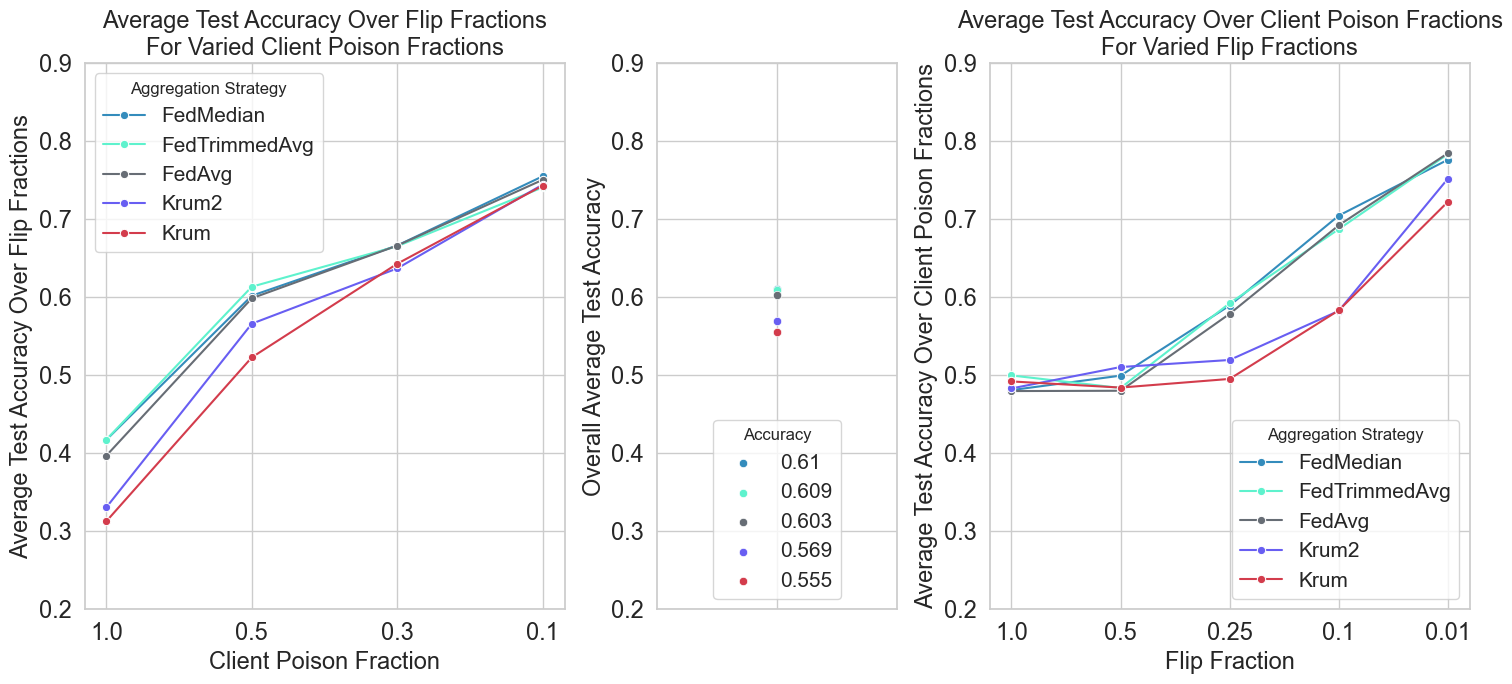

In [34]:
import matplotlib.pylab as pylab
fac = 17
params = {'legend.fontsize': f'{fac}',
          'figure.figsize': (16, 7),
         'axes.labelsize': f'{fac}',
         'axes.titlesize':f'{fac}',
         'xtick.labelsize':f'{fac}',
         'ytick.labelsize':f'{fac}',
          # 'title.size': '15'
          # 'figure.titlesize': '15' 
         }
pylab.rcParams.update(params)
fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios': [2.4, 1.2, 2.4]}, figsize=(15, 7))
color_map = {
    'FedTrimmedAvg': (94/255, 242/255, 205/255),
    'Krum': (211/255,60/255,76/255),
    'FedMedian': (52/255,140/255,188/255),
    'FedAvg': (103/255,109/255,117/255),
    # 'Krum2': (243/255,108/255,68/255),
    'Krum2': (104/255, 94/255, 242/255)
}

y_range = (0.2, 0.9)
client_poison_percent_fixed_flip_frac_varying_df.columns = ["0.1", "0.3", "0.5",'1.0', "median"]
plot_graph(client_poison_percent_fixed_flip_frac_varying_df.copy(), 
        title="Average Test Accuracy Over Flip Fractions\nFor Varied Client Poison Fractions",
           x_label="Client Poison Fraction", 
           y_label="Average Test Accuracy Over Flip Fractions", 
           # dataset=dataset, 
           # node_slice_method = node_slice_method,
           ax = ax[0], 
           color_map = color_map, 
           inverse_x_ticks = True, 
           y_range=y_range,
           fac=fac,
            loc='upper left'
          )

median_y_label = "Overall Average Test Accuracy"
plot_median(client_poison_percent_fixed_flip_frac_varying_df.copy(), ax=ax[1], color_map=color_map, median_y_label=median_y_label, y_range=y_range)

plot_graph(flip_frac_fixed_overlap_perc_varying_df.copy(), 
        title="Average Test Accuracy Over Client Poison Fractions\nFor Varied Flip Fractions",
           x_label="Flip Fraction", 
           y_label="Average Test Accuracy Over Client Poison Fractions", 
           # dataset=dataset, 
           # node_slice_method = node_slice_method,
           ax = ax[2], 
           color_map = color_map, 
           inverse_x_ticks = True, 
           y_range=y_range,
           fac=fac,
            loc='lower right'
          )

plt.tight_layout()

output_dir = f"outputs/figs"
os.makedirs(output_dir, exist_ok=True)

plt.savefig(f"{output_dir}/poisoning.pdf")
plt.savefig(f"{output_dir}/poisoning.png")

plt.show()
